# Algorithm 3

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from cmap import Colormap
from scipy.special import comb
from scipy import integrate
from scipy import special
from itertools import combinations_with_replacement
from collections import Counter
from functions import *
from trajectory_generator import *

## Computation of eigenvalues and eigenvectors

In [2]:
d = 2 # dimension
m = 6
n = 20
rm = comb(m+d,d, exact = True) # dimension of V_{p,m}
rn = comb(n+d,d, exact = True) # dimension of V_{p,n}
N = 1000 # number of sample

# Henon map
def henon(x, a=1.4, b=0.3):
  return np.array([x[1] + 1 - a*x[0]**2, b*x[0]])
def compute_henon_fixed_pts(a=1.4, b=0.3):
  return np.array([[(b-1 + np.sqrt((b-1)**2+4*a))/(2*a), b*(b-1 + np.sqrt((b-1)**2+4*a))/(2*a)],
                    [(b-1 - np.sqrt((b-1)**2+4*a))/(2*a), b*(b-1 - np.sqrt((b-1)**2+4*a))/(2*a)]]).T
f = henon # dynamical system
ps = compute_henon_fixed_pts()[:,[0]] #fixed points for computation

# Flow map of van der Pol oscillator
# Ts=0.5
# f = lambda x: VanderPol(1.0).evaluate(x, t=Ts, h=1e-4) # dynamical system
# ps = np.zeros((2,1)) #fixed points for computation

# Computation of V_n^X and W_m^{X,Y}
constV = constV_exp
sigma_kernel = 0.6 #sigma
b = np.zeros((2,1))
r_ps = ps.shape[1] #number of the fixed points
X = 0.5*np.random.rand(d,N) - 0.25 # Uniformly random sapmling
VsX = np.zeros((r_ps,rn,N))
VsY = np.zeros((r_ps,rm,N))
for i in range(r_ps):
  VsX[i]  = constV(X + ps[:,[i]], ps[:,[i]], n, sigma_kernel, b) # V_n^X
  VsY[i]  = constV(f(X + ps[:,[i]]), ps[:,[i]], m, sigma_kernel, b) # V_n^Y

#Computation of A
Cs = (VsY@(np.linalg.pinv(VsX)))[...,:rm] #exponential kernel
# Computation of eigenvalues and eigenvectors
# evals_PF, e_vecs_PF = np.linalg.eig(As)
evals_Ko, evecs_Ko = np.linalg.eig(Cs.transpose(0,2,1))

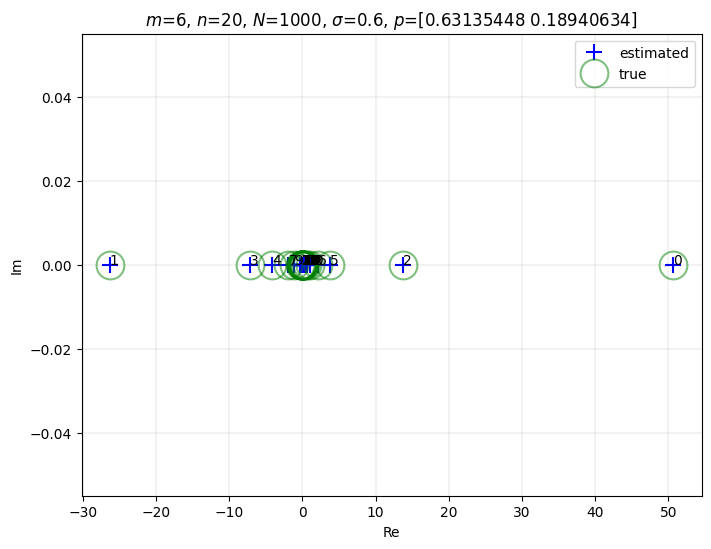

In [3]:
for i in range(r_ps):
  # Jacobian matrix of the dynamical system at 0
  dfp=jacmat(ps[:,[i]],f)
  
  # eigenvalues of the Jacobian matrix of the vector field at 0
  eval_dfp=np.linalg.eig(dfp)[0][0]  
  
  # make the array of multiplications of eigenvalues
  evals_true =np.array([np.prod(ell, axis=0) for ell in combinations_with_replacement([1 + 0j] + list(eval_dfp),m)]) 

  # figures
  ax=plt.figure(figsize=(8,6)).add_subplot()
  ax.set_title(f'$m$={m}, $n$={n}, $N$={N}, $\sigma$={sigma_kernel}, $p$={ps[:,i]}')
  ax.grid(True, linestyle='--', color='k', linewidth=0.1)
  ax.plot(evals_Ko[i].real, evals_Ko[i].imag,  '+', c='blue', markersize=12, markeredgewidth=1.5, label='estimated')
  ax.plot(evals_true.real, evals_true.imag, 'go', alpha=0.5, markerfacecolor='none', markersize=20, markeredgewidth=1.5, label='true')
  ax.set_xlabel('Re')
  ax.set_ylabel('Im')
  # ax.set_xlim(-0.5,0.1) # adjust the range of x
  ax.legend()
  # add the indices of estimated eigenvalues (to specify eval_idx)
  for j, txt in enumerate(range(rm)):
    ax.annotate(txt, (evals_Ko[i].real[j], evals_Ko[i].imag[j]))
  plt.show()

## Heat maps of eigenfunctions

### Construction of eigenfunctions

In [4]:
Gs=make_Gs(m,ps,sigma_kernel,deg=20)
Gs_diag=np.zeros((r_ps,rm, r_ps,rm))
for i in range(r_ps):
  Gs_diag[i,[i for i in range(rm)],i,[i for i in range(rm)]] = Gs[i,[i for i in range(rm)],i,[i for i in range(rm)]]

# Computation of H_ij's
Hs = np.linalg.pinv(Gs.reshape(r_ps*rm,r_ps*rm), hermitian=True)@Gs_diag.reshape(r_ps*rm,r_ps*rm)

def eigenfunction(x, eval_idx, ps_idx): #eval_idx = index of eigenvalues, ps_idx = index of the fixed points
  efunc = np.zeros(x.shape[1:], dtype=complex)
  for i in range(r_ps):
    efunc += (constV(x,ps[:,[i]],m,sigma_kernel,b).T@Hs[i*rm:(i+1)*rm,ps_idx*rm:(ps_idx+1)*rm]@evecs_Ko[ps_idx,:,eval_idx]).T
  return efunc
  
mesh=100 # number of mesh
area= 1.5 # range of the heat map

x,y=np.meshgrid(*[np.linspace(-area,area,mesh)]*2)
xy =np.array([np.ravel(x),np.ravel(y)])

eval_idx=11
ps_idx=0
ef = eigenfunction(xy, eval_idx=eval_idx, ps_idx=ps_idx)

### Heat maps of absolute values

(-1.5, 1.5)

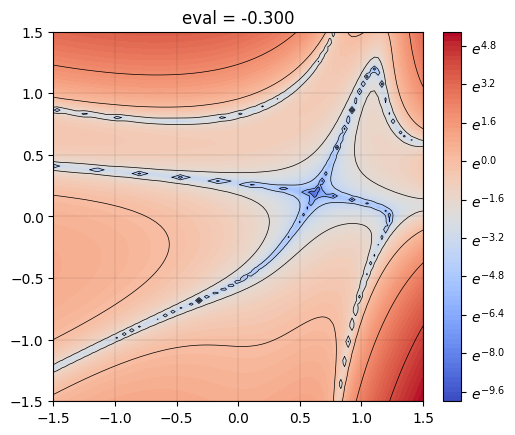

In [5]:
fig, ax=plt.subplots()
z_abs=np.log(1e-14+np.abs(ef)).reshape(mesh, mesh)
CS = ax.contourf(x, y, z_abs, 100, cmap=Colormap('coolwarm').to_mpl())
CS_level = ax.contour(CS, levels=CS.levels[::10], colors='k', linewidths=0.5, linestyles='solid') 
cbar=fig.colorbar(CS, fraction=0.0458, pad=0.04) #magical parameter to fit color bar 
cbar.set_ticklabels([f'$e^{{{x:.1f}}}$' for x in CS.levels])
ax.set_title(f'eval = {evals_Ko[ps_idx, eval_idx]:.3f}')
ax.grid(True, linestyle='--', color='k', linewidth=0.1)
ax.set_aspect('equal', 'box')
ax.set_xlim(-area,area)
ax.set_ylim(-area,area)

### Heat map of argument

(-1.5, 1.5)

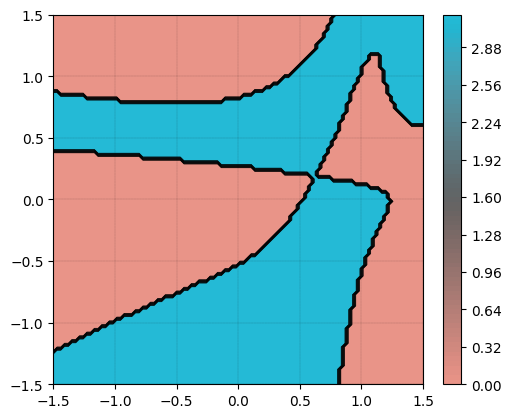

In [6]:
fig, ax=plt.subplots()
z_arg=np.angle(ef).reshape(mesh, mesh)
CS = ax.contourf(x, y, z_arg, 100, cmap=Colormap('cet_cbtc1').to_mpl(),vmin=-np.pi, vmax=np.pi)
CS_level = ax.contour(CS, levels=CS.levels[::10], colors='k', linewidths=0.5, linestyles='solid') 
cbar=fig.colorbar(CS, fraction=0.0458, pad=0.04) #magical parameter to fit color bar 
ax.grid(True, linestyle='--', color='k', linewidth=0.1)
ax.set_aspect('equal', 'box')
ax.set_xlim(-area,area)
ax.set_ylim(-area,area)

## Heat maps of absolute values with domain of attractions (for Henon map)

### Attractor and domain of attraction of the Henon map

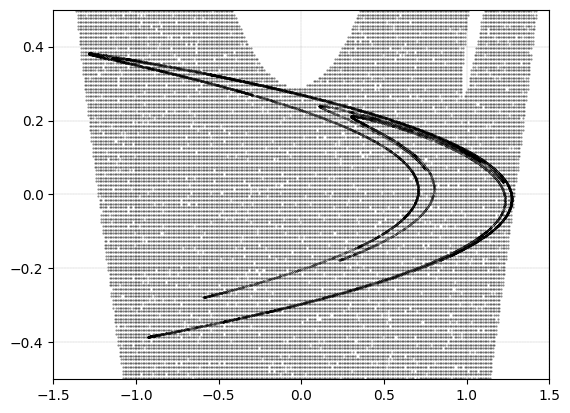

In [7]:


xx,yy=np.meshgrid(*[np.linspace(-area,area,300)]*2)

domain_of_attraction =np.array([np.ravel(xx),np.ravel(yy)])
traj=np.copy(domain_of_attraction)
for _ in range(100):
  traj = henon(traj)
  traj[:,np.sum(np.abs(traj), axis=0)>1e5] = traj[:,np.sum(np.abs(traj), axis=0)>1e5]*0 + 1e5

domain_of_attraction = np.array([np.ravel(xx),np.ravel(yy)])[:,np.sum(np.abs(traj), axis=0)<area]
attractor_henon=np.zeros((2, 20000))
for _ in range(100):
  attractor_henon[:,0] = henon(attractor_henon[:,0])
for i in range(20000-1):
  attractor_henon[:,i+1] = henon(attractor_henon[:,i])


ax=plt.figure().add_subplot()
ax.grid(True, linestyle='--', color='k', linewidth=0.1)
ax.scatter(attractor_henon[0], attractor_henon[1], 0.1,'k', '.', alpha=0.5)
ax.scatter(domain_of_attraction[0], domain_of_attraction[1], 1, 'k', '.', alpha=0.5)
ax.set_xlim(-1.5,1.5)
ax.set_ylim(-0.5,0.5)
plt.show()

(-1.5, 1.5)

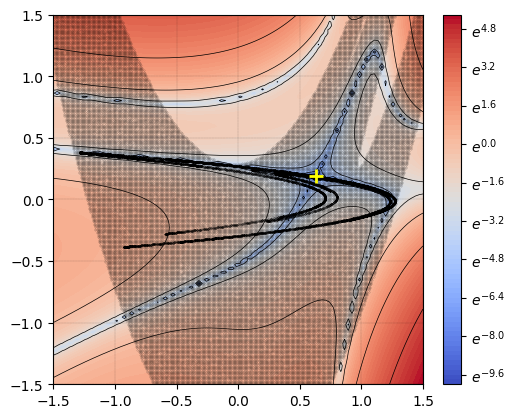

In [8]:
fig, ax=plt.subplots()
z_abs=np.log(1e-14+np.abs(ef)).reshape(mesh, mesh)
CS = ax.contourf(x, y, z_abs, 100, cmap=Colormap('coolwarm').to_mpl())
CS_level = ax.contour(CS, levels=CS.levels[::10], colors='k', linewidths=0.5, linestyles='solid') 
cbar=fig.colorbar(CS, fraction=0.0458, pad=0.04) # magical parameter to fit the color bar 
cbar.set_ticklabels([f'$e^{{{x:.1f}}}$' for x in CS.levels])
ax.grid(True, linestyle='--', color='k', linewidth=0.1)
ax.scatter(attractor_henon[0], attractor_henon[1], 0.1,'k', '.', alpha=0.5) # draw the attractor
ax.scatter(domain_of_attraction[0], domain_of_attraction[1], 0.1, 'k', '.', alpha=0.5) # draw the domain of attarction
ax.plot(ps[[0],:], ps[[1],:], '+', color='yellow', alpha=1, markerfacecolor='none', markersize=10, markeredgewidth=2) #indicates the fixed points
ax.set_aspect('equal', 'box')
ax.set_xlim(-area,area)
ax.set_ylim(-area,area)